In [1]:
import os, cv2
import itertools
from tqdm import tqdm 
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [2]:
train_imgs = np.load("train_images.npy", allow_pickle=True)
train_labels = np.load("train_labels.npy", allow_pickle=True)

In [4]:
val_imgs = np.load("val_imgs.npy", allow_pickle=True)
val_labels = np.load("val_labels.npy", allow_pickle=True)

In [5]:
img = train_imgs[0]
msk = train_labels[0]
print(img.shape,msk.shape)

(128, 256, 256, 1) (128, 256, 256, 1)


(128, 256, 256, 1) (128, 256, 256, 1)


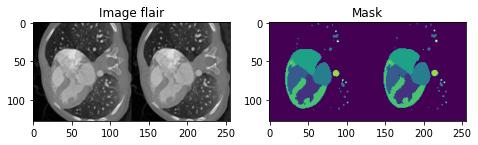

In [7]:
import random

test_img=img
test_mask=msk
print(test_img.shape,test_mask.shape)
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_img[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [8]:
val, counts = np.unique(test_mask, return_counts=True)
print(val, counts,len(val),len(counts))

[0.         0.14285714 0.16666667 0.28571429 0.33333333 0.42857143
 0.57142857 0.66666667 0.71428571 0.83333333 0.85714286 1.        ] [7387954   71998    1292   84828    5355  236093  181586    6578  172489
   30179   78722  131534] 12 12


In [9]:
df = pd.read_csv("weights.csv")

In [10]:
label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
label_4 = df['4'].sum()
label_5 = df['5'].sum()
label_6 = df['6'].sum()
label_7 = df['7'].sum()
label_8 = df['8'].sum()
label_9 = df['9'].sum()
label_10 = df['10'].sum()
label_11 = df['11'].sum()
label_12 = df['12'].sum()

In [11]:
total_labels = label_0 + label_1 + label_2 + label_3 + label_4 + label_5 + label_6 + label_7 + label_8 + label_9 + label_10 + label_11 + label_12
n_classes = 13

wt0 = round((total_labels/(n_classes*label_0)), 2) 
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)
wt4 = round((total_labels/(n_classes*label_4)), 2) 
wt5 = round((total_labels/(n_classes*label_5)), 2)
wt6 = round((total_labels/(n_classes*label_6)), 2)
wt7 = round((total_labels/(n_classes*label_7)), 2)
wt8 = round((total_labels/(n_classes*label_8)), 2) 
wt9 = round((total_labels/(n_classes*label_9)), 2)
wt10 = round((total_labels/(n_classes*label_10)), 2)
wt11 = round((total_labels/(n_classes*label_11)), 2)
wt12 = round((total_labels/(n_classes*label_12)), 2)

In [12]:
import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3,wt4, wt5, wt6, wt7,wt8, wt9, wt10, wt11, wt12])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

Segmentation Models: using `keras` framework.


In [13]:
import tensorflow as tf
LR = 0.001
optim = tf.keras.optimizers.Adam(LR)

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 

In [15]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    s = inputs
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(p3)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    
    return model

In [16]:
model = simple_unet_model(128,256,256,1,13)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 256, 25 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 128, 256, 256 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 256, 256 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 256, 256 6928        dropout[0][0]                    
______________________________________________________________________________________________

In [17]:
model.compile(optimizer = optim, loss=total_loss, metrics=metrics)

In [18]:
history=model.fit(train_imgs,train_labels,epochs=100,batch_size=1,
                      validation_data=(val_imgs,val_labels),verbose=1)    

model.save('3d_tomography.h5')

Epoch 1/100


ResourceExhaustedError:  OOM when allocating tensor with shape[1,16,128,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/dropout/dropout/ArithmeticOptimizer/ReorderCastLikeAndValuePreserving_float_Cast}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_2659]

Function call stack:
train_function
